# Hybrid Quantum-Classical Model Exploration

## Overview

This notebook is inspired from https://opg.optica.org/viewmedia.cfm?r=1&rwjcode=opticaq&uri=opticaq-3-3-238&html=true and demonstrates a comparison between hybrid quantum-classical models and traditional linear models for image classification using the MNIST dataset. The implementation leverages the Merlin framework for quantum neural networks and PyTorch for classical neural networks.

## Key Components

### 1. Model Architectures

#### QuantumReservoir Model
The main hybrid architecture combines:
- A quantum layer processing PCA-reduced image features
- A linear classifier operating on the concatenation of the original flattened image and quantum output

#### Linear Model
A simple linear classifier operating directly on flattened image features, serving as a baseline for comparison.

#### PCA Model
A linear classifier operating on PCA-reduced features to evaluate the information content of the dimensionality reduction.

### 2. Data Preparation

- The MNIST dataset (Perceval Quest subset) is loaded using the custom `mnist_digits` module
- Images are flattened and normalized
- Principal Component Analysis (PCA) reduces feature dimensionality to a specified number of components



In [171]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
import random
import time

import perceval as pcvl  # just to display the circuit

from merlin import PhotonicBackend as Experiment
from merlin import CircuitType
from merlin import AnsatzFactory
from merlin import QuantumLayer
from merlin import OutputMappingStrategy
from merlin import StatePattern

In [133]:
# Simple Baseline Linear Model
class LinearModelBaseline(nn.Module):
    def __init__(self, image_size, num_classes=10):
        super(LinearModelBaseline, self).__init__()
        self.image_size = image_size

        # Classical part
        self.classifier = nn.Linear(image_size, num_classes)

    def forward(self, x):
        # Data is already flattened
        output = self.classifier(x)
        return output

In [149]:
# LinearModel with PCA
class LinearModelPCA(nn.Module):
    """
    Linear model for classification using PCA features and the raw MNIST data.

    Attributes:
        image_size (int): Dimensionality of the raw MNIST data.
        pca_components (int): Number of PCA components.
        only_use_pca (bool): Indicates whether to ignore raw data or not.
        use_batch_norm (bool): Indicates whether to use batch normalization or not.
        bn_pca (nn.BatchNorm1d): The batch normalization layer for PCA features.
        bn_raw_mnist (nn.BatchNorm1d): The batch normalization layer for raw MNIST data.
        classifier (nn.Linear): The linear layer performing classification.

    Args:
        image_size (int): Dimensionality of the raw MNIST data.
        pca_components (int): Number of PCA components.

        num_classes (int): Number of output classes.
        only_use_pca (bool): Indicates whether to ignore raw data or not.
        use_batch_norm (bool): Indicates whether to use batch normalization or not.

    Note that we use two different batch normalization layers because the PCA features and the raw MNIST data can have different scales.
    """
    def __init__(self, image_size, pca_components, num_classes=10, only_use_pca=False, use_batch_norm=True):
        super(LinearModelPCA, self).__init__()
        self.image_size = image_size
        self.pca_components = pca_components
        self.only_use_pca = only_use_pca
        self.use_batch_norm = use_batch_norm

        # Batch norm layers
        self.bn_pca = nn.BatchNorm1d(pca_components)
        self.bn_raw_mnist = nn.BatchNorm1d(image_size)

        # Classical part
        if only_use_pca:
            self.classifier = nn.Linear(pca_components, num_classes)
        else:
            self.classifier = nn.Linear(image_size + pca_components, num_classes)

    def forward(self, x, x_pca):
        # Data is already flattened
        if self.use_batch_norm:
            x_pca = self.bn_pca(x_pca)
            x = self.bn_raw_mnist(x)

        if self.only_use_pca:
            output = self.classifier(x_pca)
        else:
            combined_features = torch.cat((x, x_pca), dim=1)
            output = self.classifier(combined_features)
        return output

In [150]:
# Scale layer used in Hybrid model
class ScaleLayer(nn.Module):
    """
        Multiply the input tensor by a learned or fixed factor.

        Args:
            dim (int): Dimension of the input data to be encoded.
            scale_type (str): ["1", "learned", "2pi", "pi", "/2pi", "/pi", "2", "0.1"] Type of scaling method.

        Returns: nn.Module that multiplies the input tensor by a learned or fixed factor.
    """
    def __init__(self, dim, scale_type = "learned"):
        super(ScaleLayer, self).__init__()
        # Create a single learnable parameter (initialized to 0.1 by default)
        if scale_type == "learned":
            self.scale = nn.Parameter(torch.full((dim,), 1.0))
        elif scale_type == "2pi":
            self.scale = torch.full((dim,), 2 * torch.pi)
        elif scale_type == "2":
            self.scale = torch.full((dim,), 2.0)
        elif scale_type == "pi":
            self.scale = torch.full((dim,), torch.pi)
        elif scale_type == "/pi":
            self.scale = torch.full((dim,), 1 / torch.pi)
        elif scale_type == "1":
            self.scale = torch.full((dim,), 1)
        elif scale_type == "0.1":
            self.scale = torch.full((dim,), 0.1)
        elif scale_type == "/2pi":
            self.scale = torch.full((dim,), 1 / (2 * torch.pi))

    def forward(self, x):
        # Element-wise multiplication of each input element by the learned scale
        return x * self.scale

In [151]:
# definition of HybridModel class - quantum reservoir applying on pca, and linear classifier on raw input and quantum output
class HybridModel(nn.Module):
    """
    Hybrid model for classification using PCA features and the raw MNIST data.
    PCA features are sent in the quantum reservoir. The output is concatenated with the raw MNIST data and then sent through a classical linear layer for classification.

    Attributes:
        image_size (int): Dimensionality of the raw MNIST data.
        pca_components (int): Number of PCA components.
        n_modes (int): Number of modes for the quantum reservoir.
        n_photons (int): Number of photons sent through the quantum reservoir.
        only_use_pca (bool): Indicates whether to ignore raw data or not.
        manual_circuit (bool): Indicates whether to define circuit manually or with the AnsatzFactory feature.
        use_batch_norm (bool): Indicates whether to use batch normalization or not.
        photons_at_start (bool): Indicates whether to place photons sequentially on the first modes or whether to spread them on the modes. Example: True ---> [1, 1, 0, 0]; False ---> [1, 0, 1, 0].

        bn_q (nn.BatchNorm1d): The batch normalization layer for the output of the quantum reservoir.
        bn_raw_mnist (nn.BatchNorm1d): The batch normalization layer for raw MNIST data.
        scaler (ScaleLayer): Scale layer for the input of the quantum reservoir (PCA features).
        quantum_reservoir (QuantumLayer): The quantum reservoir.
        classifier (nn.Linear): The linear layer performing classification.

    Args:
        image_size (int): Dimensionality of the raw MNIST data.
        pca_components (int): Number of PCA components.
        n_modes (int): Number of modes for the quantum reservoir.
        n_photons (int): Number of photons sent through the quantum reservoir.

        num_classes (int): Number of output classes.
        scale_type (str): ["1", "learned", "2pi", "pi", "/2pi", "/pi", "2", "0.1"] Type of scaling method for the ScaleLayer.
        only_use_pca (bool): Indicates whether to ignore raw data or not.
        manual_circuit (bool): Indicates whether to define circuit manually or with the AnsatzFactory feature.
        use_batch_norm (bool): Indicates whether to use batch normalization or not.
        photons_at_start (bool): Indicates whether to place photons sequentially on the first modes or whether to spread them on the modes. Example: True ---> [1, 1, 0, 0]; False ---> [1, 0, 1, 0].

    Note that we use two different batch normalization layers because the quantum output and the raw MNIST data have very different scales. Indeed, the quantum outputs are probabilities so they sum up to 1 for each batch element. This implies that the values of th quantum outputs are much smaller than the values of raw MNIST data. These two batch normalization layers then serve as a balancing tool for the final linear layer.
    """
    def __init__(self, image_size, pca_components, n_modes, n_photons, num_classes=10, scale_type="1", only_use_pca=False, manual_circuit=True, use_batch_norm=True, photons_at_start=True):
        super(HybridModel, self).__init__()
        self.image_size = image_size
        self.pca_components = pca_components
        self.n_modes = n_modes
        self.n_photons = n_photons
        self.only_use_pca = only_use_pca
        self.manual_circuit = manual_circuit
        self.use_batch_norm = use_batch_norm
        self.photons_at_start = photons_at_start

        # We cannot define the batch norm layer for the quantum output now since we don't know its size.
        self.bn_q = None
        self.bn_raw_mnist = None

        # Scale Layer
        self.scaler = ScaleLayer(pca_components, scale_type=scale_type)

        # Quantum part (non-trainable reservoir) defined manually or automatically using AnsatzFactory
        if self.manual_circuit:
            self.quantum_reservoir = self._create_quantum_reservoir_manual(pca_components, n_modes, n_photons)
        else:
            self.quantum_reservoir = self._create_quantum_reservoir(pca_components, n_modes, n_photons)

        # Classical part, Linear layer
        if self.only_use_pca:
            self.classifier = nn.Linear(self.quantum_reservoir.output_size, num_classes)
            total_features = self.quantum_reservoir.output_size
        else:
            self.classifier = nn.Linear(image_size + self.quantum_reservoir.output_size,num_classes)
            total_features = image_size + self.quantum_reservoir.output_size

        print(f"\nQuantum Reservoir Created:")
        print(f"  Input size (PCA components): {pca_components}")
        print(f"  Quantum output size: {self.quantum_reservoir.output_size}")
        print(f"  Total features to classifier: {total_features}")

    def _create_quantum_reservoir(self, input_size, n_modes, n_photons):
        """Create quantum layer with Series circuit in reservoir mode."""

        # Create experiment with Series circuit
        experiment = Experiment(
            circuit_type=CircuitType.SERIES,
            n_modes=n_modes,
            n_photons=n_photons,
            reservoir_mode=True,  # Non-trainable quantum layer
            use_bandwidth_tuning=False,  # No bandwidth tuning
            state_pattern=StatePattern.PERIODIC
        )

        # Create ansatz with automatic output size
        ansatz = AnsatzFactory.create(
            PhotonicBackend=experiment,
            input_size=input_size,
            # output_size not specified - will be calculated automatically
            output_mapping_strategy=OutputMappingStrategy.NONE
        )

        # Create quantum layer
        quantum_layer = QuantumLayer(
            input_size=input_size,
            ansatz=ansatz,
            #shots=10000,  # Number of measurement shots
            no_bunching=False
        )

        return quantum_layer

    def _create_circuit_manual(self, input_size, n_modes):
        # Random circuit
        left_side = pcvl.GenericInterferometer(n_modes,
                                lambda idx: pcvl.BS(theta=np.pi*2*random.random()) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * n_modes,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))

        # Encoding of input
        center = pcvl.Circuit(n_modes)
        for i in range(input_size):
            param = pcvl.P(f"px_{i}")
            center.add(i, pcvl.PS(param))

        # Random circuit
        right_side = pcvl.GenericInterferometer(n_modes,
                                lambda idx: pcvl.BS(theta=np.pi*2*random.random()) // (0, pcvl.PS(phi=np.pi * 2 * random.random())),
                                shape=pcvl.InterferometerShape.RECTANGLE,
                                depth=2 * n_modes,
                                phase_shifter_fun_gen=lambda idx: pcvl.PS(phi=np.pi*2*random.random()))

        # Resulting circuit
        circuit = pcvl.Circuit(n_modes)
        circuit.add(0, left_side, merge=True)
        circuit.add(0, center, merge=True)
        circuit.add(0, right_side, merge=True)
        return circuit

    def _create_input_state(self, n_photons, n_modes):
        input_state = [0] * n_modes
        i = 0
        index = 0
        while i < n_photons:
            if self.photons_at_start:
                input_state[i] = 1
            else:
                input_state[index] = 1
            index += n_modes // n_photons
            i += 1
        print(f"Input state : {input_state}")
        return input_state

    def _create_quantum_reservoir_manual(self, input_size, n_modes, n_photons):
        circuit = self._create_circuit_manual(input_size, n_modes)
        input_state = self._create_input_state(n_photons, n_modes)
        reservoir = QuantumLayer(
                input_size=input_size,
                circuit=circuit,
                trainable_parameters=[],
                input_parameters=["px"],
                input_state=input_state,
                #shots=10000,  # Number of measurements
                no_bunching=False,
                output_mapping_strategy=OutputMappingStrategy.NONE
            )

        return reservoir

    def forward(self, x, x_pca):
        # Scale PCA features (range [0, 1]) through scaler
        scaled_pca = self.scaler(x_pca)
        # Process the PCA-reduced input through quantum layer
        quantum_output = self.quantum_reservoir(scaled_pca)

        if self.only_use_pca:
            output = self.classifier(quantum_output)
        else:
            # Concatenate original image features with quantum output
            if self.use_batch_norm:
                # Instantiate batch norm layer if not already done
                if self.bn_q is None:
                    self.bn_q = nn.BatchNorm1d(quantum_output.shape[1])
                # Instantiate batch norm layer if not already done
                if self.bn_raw_mnist is None:
                    self.bn_raw_mnist = nn.BatchNorm1d(x.shape[1])

                combined_features = torch.cat((self.bn_raw_mnist(x), self.bn_q(quantum_output)), dim=1)
            else:
                combined_features = torch.cat((x, quantum_output), dim=1)

            # Final classification
            output = self.classifier(combined_features)

        return output

In [173]:
from merlin.datasets import mnist_digits

def get_mnist_data(source="percevalquest", normalization="none"):
    """
    Get MNIST dataset. Images are flattened. Images and labels are stored in Torch.tensors.

    Args:
        source (str): ["percevalquest", "full_dataset"] Indicates whether to use the percevalquest subset (Training set: 6K, Test set: 1K) or the full dataset (Training set: 60K, Test set: 10K).
        normalization (str): ["min_max", "none"] Indicates whether to normalize the dataset or not.

    Returns:
        X_train, y_train, X_test, y_test
    """
    if source == "percevalquest":
        train_features, train_labels, train_metadata = mnist_digits.get_data_train_percevalquest()
        test_features, test_labels, test_metadata = mnist_digits.get_data_test_percevalquest()
    elif source == "full_dataset":
        # Define transform: convert images to tensors and normalize
        transform = transforms.ToTensor()

        # Download training data (60,000 samples)
        train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

        # Separate images and labels
        train_features = torch.stack([data[0] for data in train_dataset])  # shape: [60000, 1, 28, 28]
        train_labels = torch.tensor([data[1] for data in train_dataset])  # shape: [60000]

        # Download test data (10,000 samples)
        test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

        test_features = torch.stack([data[0] for data in test_dataset])
        test_labels = torch.tensor([data[1] for data in test_dataset])
    else:
        raise ValueError(f"Unknown source: {source}")

    # Flatten the images from (N, 28, 28) to (N, 784)
    train_features = train_features.reshape(train_features.shape[0], -1)
    test_features = test_features.reshape(test_features.shape[0], -1)

    if normalization == "min_max":
        scaler = MinMaxScaler()
        train_features = scaler.fit_transform(train_features)
        test_features = scaler.transform(test_features)

    # Convert data to PyTorch tensors
    X_train = torch.FloatTensor(train_features)
    y_train = torch.LongTensor(train_labels)
    X_test = torch.FloatTensor(test_features)
    y_test = torch.LongTensor(test_labels)

    print(f"Dataset loaded: {len(X_train)} training samples, {len(X_test)} test samples")
    print(f"Train dataset shape : {X_train.shape}")
    print(f"Train label shape : {y_train.shape}")
    return X_train, y_train, X_test, y_test


source = "percevalquest"
initial_normalization = "min_max"
X_train, y_train, X_test, y_test = get_mnist_data(source, normalization=initial_normalization)

Dataset loaded: 6000 training samples, 600 test samples
Train dataset shape : torch.Size([6000, 784])
Train label shape : torch.Size([6000])


In [183]:
M=16
N=3
# Paper uses n_components = M
n_components=M-1

In [184]:
# train PCA
def train_pca(X_train, X_test):
    """
    Train PCA on flat training and test images.

    Args:
        X_train (torch.FloatTensor): Flat training images.
        X_test (torch.FloatTensor): Flat test images.

    Returns:
        X_train_pca, X_test_pca
    """
    pca = PCA(n_components=n_components)

    pca.fit(X_train)
    X_train_pca = torch.FloatTensor(pca.transform(X_train))
    X_test_pca = torch.FloatTensor(pca.transform(X_test))

    # Compute min and max from the training set
    min_val = X_train_pca.min()
    max_val = X_train_pca.max()

    # Avoid division by zero if max == min
    if max_val == min_val:
        raise ValueError("Cannot scale: all values in X_train_pca are the same.")

    # Scale both train and test using training set stats, to have PCA features between 0 and 1
    X_train_pca = (X_train_pca - min_val) / (max_val - min_val)
    X_test_pca = (X_test_pca - min_val) / (max_val - min_val)

    return X_train_pca, X_test_pca

X_train_pca, X_test_pca = train_pca(X_train, X_test)

In [194]:
# define corresponding linear model for comparison
linear_model = LinearModelBaseline(X_train_flat.shape[1])

In [195]:
only_use_pca = False
use_batch_norm =True
# define classic model using pca features
pca_model = LinearModelPCA(X_train_flat.shape[1], n_components, only_use_pca=only_use_pca, use_batch_norm=use_batch_norm)

In [196]:
scale_type = "2"  # ["1", "learned", "/pi", "/2pi", "pi", "2pi"]
manual_circuit = True
photons_at_start = False
weight_decay = 1e-2
num_epochs = 100

# define hybrid model
hybrid_model = HybridModel(X_train_flat.shape[1], n_components, n_modes=M, n_photons=N, only_use_pca=only_use_pca, scale_type=scale_type, manual_circuit=manual_circuit, use_batch_norm=use_batch_norm, photons_at_start=photons_at_start)

Input state : [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]

Quantum Reservoir Created:
  Input size (PCA components): 15
  Quantum output size: 816
  Total features to classifier: 1600


In [197]:
def get_run_info():
    s = "#######################################################################################\n"
    s += f"N_M = {N}_{M}\n"
    s += f"only_use_pca = {only_use_pca}\n"
    s += f"scale_type = {scale_type}\n"
    s += f"manual_circuit = {manual_circuit}\n"
    s += f"batch_norm = {batch_norm}\n"
    s += f"photons_at_start = {photons_at_start}\n"
    s += f"weight_decay = {weight_decay}\n"
    s += f"num_epochs = {num_epochs}\n"
    return s

In [198]:
def train(X_train_pca, X_train, X_test_pca, X_test, optimizer="Adagrad"):
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()

    if optimizer == "Adagrad":
        optimizer_linear = torch.optim.Adagrad(linear_model.parameters(), lr=0.05, weight_decay=weight_decay/100)
        optimizer_pca = torch.optim.Adagrad(pca_model.parameters(), lr=0.05, weight_decay=weight_decay/100)
        optimizer_hybrid = torch.optim.Adagrad(hybrid_model.parameters(), lr=0.05, weight_decay=weight_decay)
    elif optimizer == "Adam":
        optimizer_linear = torch.optim.Adam(linear_model.parameters(), lr=0.001, weight_decay=weight_decay/100)
        optimizer_pca = torch.optim.Adam(pca_model.parameters(), lr=0.001, weight_decay=weight_decay/100)
        optimizer_hybrid = torch.optim.Adam(hybrid_model.parameters(), lr=0.001, weight_decay=weight_decay)
    else:
        raise NotImplementedError

    # Create DataLoader for batching

    # Old batch_size
    #batch_size = 128

    # Batch_size = 100
    batch_size = 100

    train_dataset = torch.utils.data.TensorDataset(X_train, X_train_pca, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    #num_epochs = num_epochs
    hybrid_total_train_times = []

    history = {
          'hybrid': {'loss': [], 'accuracy': {'train': [], 'test': []}},
          'pca': {'loss': [], 'accuracy': {'train': [], 'test': []}},
          'linear': {'loss': [], 'accuracy': {'train': [], 'test': []}},
          'epochs': []
    }

    for epoch in range(num_epochs):
        hybrid_total_train_time = 0

        running_loss_hybrid = 0.0
        running_loss_linear = 0.0
        running_loss_pca = 0.0

        hybrid_model.train()
        linear_model.train()
        pca_model.train()

        for i, (images, pca_features, labels) in enumerate(train_loader):
            # Hybrid model - Forward and Backward pass
            time_before = time.time()
            outputs = hybrid_model(images, pca_features)
            loss = criterion(outputs, labels)
            optimizer_hybrid.zero_grad()
            loss.backward()
            optimizer_hybrid.step()
            time_after = time.time()
            hybrid_total_train_time += time_after - time_before
            running_loss_hybrid += loss.item()

            # Comparative linear model - Forward and Backward pass
            outputs = linear_model(images)
            loss = criterion(outputs, labels)
            optimizer_linear.zero_grad()
            loss.backward()
            optimizer_linear.step()
            running_loss_linear += loss.item()

            # Comparative pca model - Forward and Backward pass
            outputs = pca_model(images, pca_features)
            loss = criterion(outputs, labels)
            optimizer_pca.zero_grad()
            loss.backward()
            optimizer_pca.step()
            running_loss_pca += loss.item()

        avg_loss_hybrid = running_loss_hybrid/len(train_loader)
        avg_loss_linear = running_loss_linear/len(train_loader)
        avg_loss_pca = running_loss_pca/len(train_loader)

        history['hybrid']['loss'].append(avg_loss_hybrid)
        history['linear']['loss'].append(avg_loss_linear)
        history['pca']['loss'].append(avg_loss_pca)

        history['epochs'].append(epoch + 1)

        hybrid_model.eval()
        linear_model.eval()
        pca_model.eval()
        with torch.no_grad():
            outputs = hybrid_model(X_train, X_train_pca)
            _, predicted = torch.max(outputs, 1)
            hybrid_train_accuracy = (predicted == y_train).sum().item() / y_train.size(0)

            outputs = hybrid_model(X_test, X_test_pca)
            _, predicted = torch.max(outputs, 1)
            hybrid_test_accuracy = (predicted == y_test).sum().item() / y_test.size(0)

            outputs = linear_model(X_train)
            _, predicted = torch.max(outputs, 1)
            linear_train_accuracy = (predicted == y_train).sum().item() / y_train.size(0)

            outputs = linear_model(X_test)
            _, predicted = torch.max(outputs, 1)
            linear_test_accuracy = (predicted == y_test).sum().item() / y_test.size(0)

            outputs = pca_model(X_train, X_train_pca)
            _, predicted = torch.max(outputs, 1)
            pca_train_accuracy = (predicted == y_train).sum().item() / y_train.size(0)

            outputs = pca_model(X_test, X_test_pca)
            _, predicted = torch.max(outputs, 1)
            pca_test_accuracy = (predicted == y_test).sum().item() / y_test.size(0)

        history['hybrid']['accuracy']['train'].append(hybrid_train_accuracy)
        history['linear']['accuracy']['train'].append(linear_train_accuracy)
        history['pca']['accuracy']['train'].append(pca_train_accuracy)

        history['hybrid']['accuracy']['test'].append(hybrid_test_accuracy)
        history['linear']['accuracy']['test'].append(linear_test_accuracy)
        history['pca']['accuracy']['test'].append(pca_test_accuracy)

        print(f'\nEpoch [{epoch+1}/{num_epochs}],\nLOSS ------------ Hybrid: {avg_loss_hybrid:.4f}, Linear: {avg_loss_linear:.4f}, PCA: {avg_loss_pca:.4f}'+
              f',\nTRAIN ACCURACY -- Hybrid: {hybrid_train_accuracy:.4f}, Linear: {linear_train_accuracy:.4f}, PCA: {pca_train_accuracy:.4f},\nTEST ACCURACY --- Hybrid: {hybrid_test_accuracy:.4f}, Linear: {linear_test_accuracy:.4f}, PCA: {pca_test_accuracy:.4f}\n')
        hybrid_total_train_times.append(hybrid_total_train_time)

    run_info = get_run_info()
    print(run_info)

    hybrid_best_test_acc = max(history["hybrid"]["accuracy"]["test"])
    hybrid_best_test_acc_index = history["hybrid"]["accuracy"]["test"].index(max(history["hybrid"]["accuracy"]["test"]))

    hybrid_train_acc = history["hybrid"]["accuracy"]["train"][hybrid_best_test_acc_index]

    print(f"Hybrid best test accuracy: {hybrid_best_test_acc:.4f} and associated train accuracy {hybrid_train_acc:.4f} at epoch {hybrid_best_test_acc_index}")

    linear_best_test_acc = max(history["linear"]["accuracy"]["test"])
    linear_best_test_acc_index = history["linear"]["accuracy"]["test"].index(max(history["linear"]["accuracy"]["test"]))

    linear_train_acc = history["linear"]["accuracy"]["train"][linear_best_test_acc_index]

    print(f"Linear best test accuracy: {linear_best_test_acc:.4f} and associated train accuracy {linear_train_acc:.4f} at epoch {linear_best_test_acc_index}")

    pca_best_test_acc = max(history["pca"]["accuracy"]["test"])
    pca_best_test_acc_index = history["pca"]["accuracy"]["test"].index(max(history["pca"]["accuracy"]["test"]))

    pca_train_acc = history["pca"]["accuracy"]["train"][pca_best_test_acc_index]

    print(f"PCA best test accuracy: {pca_best_test_acc:.4f} and associated train accuracy {pca_train_acc:.4f} at epoch {pca_best_test_acc_index}")

    hybrid_mean_train_time = torch.mean(torch.Tensor(hybrid_total_train_times))
    print(f"Hybrid model mean training time for 1 epoch : {hybrid_mean_train_time:.4f}")
    return history

optimizer = "Adagrad"
history = train(X_train_pca, X_train, X_test_pca, X_test, optimizer=optimizer)


Epoch [1/100],
LOSS ------------ Hybrid: 0.4893, Linear: 0.5937, PCA: 0.5266,
TRAIN ACCURACY -- Hybrid: 0.9112, Linear: 0.9043, PCA: 0.9307,
TEST ACCURACY --- Hybrid: 0.8650, Linear: 0.8967, PCA: 0.9033


Epoch [2/100],
LOSS ------------ Hybrid: 0.2118, Linear: 0.3394, PCA: 0.2727,
TRAIN ACCURACY -- Hybrid: 0.9490, Linear: 0.9170, PCA: 0.9417,
TEST ACCURACY --- Hybrid: 0.9200, Linear: 0.9083, PCA: 0.9050


Epoch [3/100],
LOSS ------------ Hybrid: 0.1803, Linear: 0.3017, PCA: 0.2272,
TRAIN ACCURACY -- Hybrid: 0.9618, Linear: 0.9252, PCA: 0.9482,
TEST ACCURACY --- Hybrid: 0.9267, Linear: 0.9183, PCA: 0.9217


Epoch [4/100],
LOSS ------------ Hybrid: 0.1664, Linear: 0.2789, PCA: 0.2047,
TRAIN ACCURACY -- Hybrid: 0.9643, Linear: 0.9302, PCA: 0.9510,
TEST ACCURACY --- Hybrid: 0.9383, Linear: 0.9183, PCA: 0.9117


Epoch [5/100],
LOSS ------------ Hybrid: 0.1604, Linear: 0.2640, PCA: 0.1897,
TRAIN ACCURACY -- Hybrid: 0.9697, Linear: 0.9375, PCA: 0.9580,
TEST ACCURACY --- Hybrid: 0.9433, Line

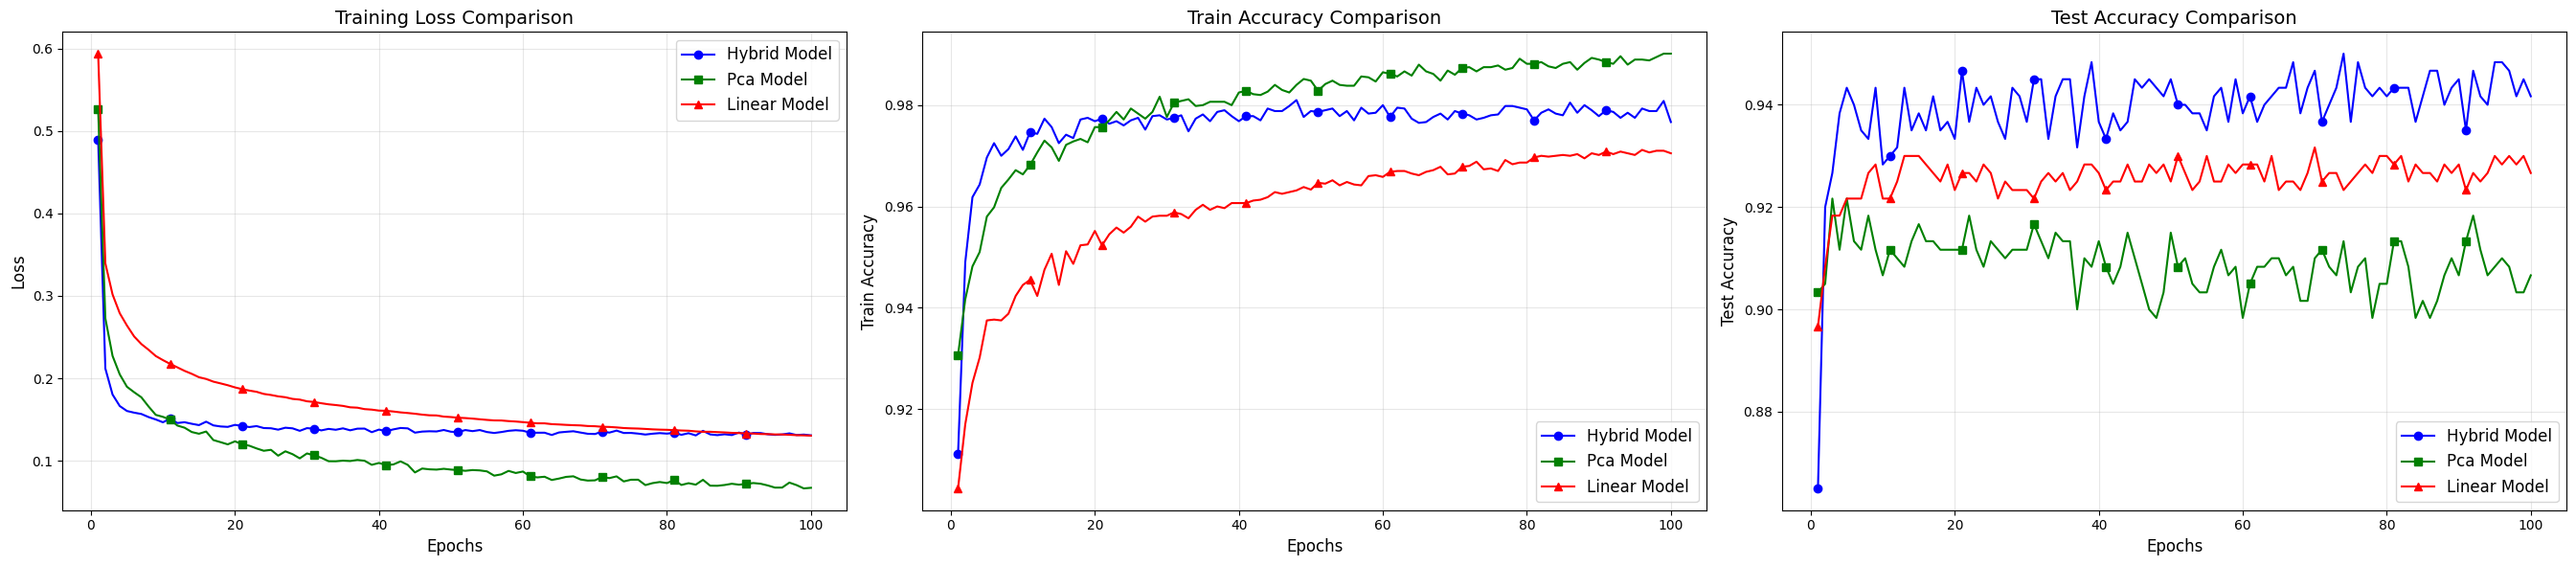

In [199]:
import matplotlib.pyplot as plt
def plot_training_comparison(history):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(27, 6))

    # Define colors and styles for consistency
    model_styles = {
      'hybrid': {'color': 'blue', 'linestyle': '-', 'marker': 'o'},
      'pca': {'color': 'green', 'linestyle': '-', 'marker': 's'},
      'linear': {'color': 'red', 'linestyle': '-', 'marker': '^'}
    }

    # Plot loss curves
    for model_name, style in model_styles.items():
      if model_name in history:
          ax1.plot(
              history['epochs'],
              history[model_name]['loss'],
              color=style['color'],
              linestyle=style['linestyle'],
              marker=style['marker'],
              markevery=max(1, len(history['epochs'])//10),  # Show markers at 10 points
              label=f'{model_name.capitalize()} Model'
          )

    ax1.set_title('Training Loss Comparison', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Plot accuracy curves
    for model_name, style in model_styles.items():
      if model_name in history:
          ax2.plot(
              history['epochs'],
              history[model_name]['accuracy']['train'],
              color=style['color'],
              linestyle=style['linestyle'],
              marker=style['marker'],
              markevery=max(1, len(history['epochs'])//10),  # Show markers at 10 points
              label=f'{model_name.capitalize()} Model'
          )
          ax3.plot(
              history['epochs'],
              history[model_name]['accuracy']['test'],
              color=style['color'],
              linestyle=style['linestyle'],
              marker=style['marker'],
              markevery=max(1, len(history['epochs'])//10),  # Show markers at 10 points
              label=f'{model_name.capitalize()} Model'
          )


    ax2.set_title('Train Accuracy Comparison', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Train Accuracy', fontsize=12)
    ax2.legend(fontsize=12)
    ax2.grid(True, alpha=0.3)

    ax3.set_title('Test Accuracy Comparison', fontsize=14)
    ax3.set_xlabel('Epochs', fontsize=12)
    ax3.set_ylabel('Test Accuracy', fontsize=12)
    ax3.legend(fontsize=12)
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig("./results/Training_quantum_reservoir.png")
    plt.show()

# Call the function to generate the plot
plot_training_comparison(history)

RBF SVC

In [216]:
# Create an RBF-kernel SVC (default kernel is 'rbf')

# One that takes the PCA as input
clf_pca = SVC(kernel='rbf', C=1.0, gamma='scale')
# And one that takes the raw input
clf = SVC(kernel='rbf', C=1.0, gamma='scale')

# Fit the model
clf_pca.fit(X_train_pca, y_train)
clf.fit(X_train, y_train)

# Predict
y_pred = clf_pca.predict(X_train_pca)
train_accuracy_pca = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf_pca.predict(X_test_pca)
test_accuracy_pca = accuracy_score(y_test, y_pred)

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Train accuracy PCA : {train_accuracy_pca:.4f}')
print(f'Test accuracy PCA : {test_accuracy_pca:.4f}')

print(f'Train accuracy raw : {train_accuracy:.4f}')
print(f'Test accuracy raw : {test_accuracy:.4f}')

Train accuracy PCA : 0.9509
Test accuracy PCA : 0.9450
Train accuracy raw : 0.9899
Test accuracy raw : 0.9792


Linear SVC

In [218]:
# Create an linear SVC

# One that takes the PCA as input
clf_pca = SVC(kernel='linear', C=1.0, gamma='scale')
# And one that takes the raw input
clf = SVC(kernel='linear', C=1.0, gamma='scale')

# Fit the model
clf_pca.fit(X_train_pca, y_train)
clf.fit(X_train, y_train)

# Predict
y_pred = clf_pca.predict(X_train_pca)
train_accuracy_pca = accuracy_score(y_train, y_pred)

y_pred = clf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred)

y_pred = clf_pca.predict(X_test_pca)
test_accuracy_pca = accuracy_score(y_test, y_pred)

y_pred = clf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print(f'Train accuracy PCA : {train_accuracy_pca:.4f}')
print(f'Test accuracy PCA : {test_accuracy_pca:.4f}')

print(f'Train accuracy raw : {train_accuracy:.4f}')
print(f'Test accuracy raw : {test_accuracy:.4f}')

Train accuracy PCA : 0.8407
Test accuracy PCA : 0.8440
Train accuracy raw : 0.9707
Test accuracy raw : 0.9404
